# Multi-Agent Coding Demo

In [1]:
import os
from dotenv import load_dotenv
import tempfile
from autogen import ConversableAgent, AssistantAgent, UserProxyAgent
from autogen.coding import LocalCommandLineCodeExecutor
from autogen.coding import DockerCommandLineCodeExecutor
import matplotlib.pyplot as plt

load_dotenv()  # take environment variables from .env.

llm_config={"config_list": [{
    "model": "gpt-4-turbo",
    "cache": None,
    "temperature": 0.9, 
    "api_key": os.environ.get("OPENAI_API_KEY")}]}


# Local Command Line Code Executor

This is not supported any more

In [2]:
# Create a temporary directory to store the code files.
#temp_dir = tempfile.TemporaryDirectory()
#print(temp_dir.name)
#temp_dir.cleanup()
temp_dir = './tmp'


# Create a local command line code executor.
local_executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": local_executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

You have to install the required packages locally for the following cell, otherwise it will fail.

In [3]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = np.random.randint(0, 100, 100)
y = np.random.randint(0, 100, 100)
plt.scatter(x, y)
plt.savefig('scatter.png')
print('Scatter plot saved to scatter.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to scatter.png



['tmp_code_e24bf32d4a21990fb9e4b5eb889ebe5a.py', '.DS_Store', 'scatter.png']


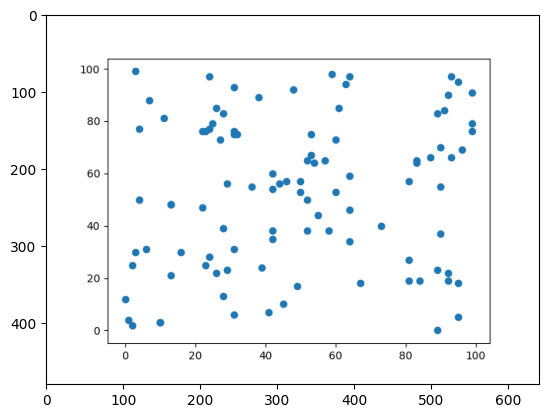

In [4]:
# print out the plot
print(os.listdir(temp_dir))

# open the scatter plot image
img = plt.imread(os.path.join(temp_dir, "scatter.png"))
plt.imshow(img)

# Docker Code Execution

In [6]:
# Create a temporary directory to store the code files.
temp_dir = './tmp'

import subprocess

def is_docker_container_running(container_name_or_id):
    try:
        # Execute the 'docker ps' command to get a list of running containers
        result = subprocess.run(['docker', 'ps'], stdout=subprocess.PIPE, text=True)
        # Return True if the container name or ID is in the output, otherwise False
        return container_name_or_id in result.stdout
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

docker_container_name = 'autogen'

# stop the docker container if it is running

if is_docker_container_running(docker_container_name):
    print(f"The Docker container {docker_container_name} is running.")
    try:
        # Execute the 'docker stop' command to stop the running container
        subprocess.run(['docker', 'stop', docker_container_name], check=True)
        print(f"Container '{docker_container_name}' has been stopped.")
        
    except subprocess.CalledProcessError:
        print(f"Failed to stop container '{docker_container_name}'.")

# https://microsoft.github.io/autogen/docs/reference/coding/docker_commandline_code_executor/
# Create a Docker command line code executor.
# this will create a docker container with the given image name and start the container to execute the code.

print(f'creating and starting the docker {docker_container_name}')
docker_executor = DockerCommandLineCodeExecutor(
    image="python:3.12-slim",  # Execute code using the given docker image name.
    container_name=docker_container_name,  # Name of the Docker container.
    timeout=180,  # Timeout for each code execution in seconds - 3 minutes
    work_dir=temp_dir,  # Use the temporary directory to store the code files.
)

creating and starting the docker autogen


In [7]:
# Create an agent with code executor configuration that uses docker.
code_executor_agent_using_docker = ConversableAgent(
    "code_executor_agent_docker",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": docker_executor},  # Use the docker command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

Try to add language identifier in  code block to language inference by LLM. 

In [8]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
print('hello world!')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent_using_docker.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: hello world!



In [9]:
message_with_code_block = """This is a message with code block.
The code block is below:
```shell
pip install matplotlib numpy
```
This is the end of the message.
"""

# Generate a reply for the given code.
# pip install -qqq matplotlib numpy is used in automatic generated code -qqq is quiet model to keep the log clean
reply = code_executor_agent_using_docker.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is shell)...
exitcode: 0 (execution succeeded)
Code output: 


In [ ]:
message_with_code_block = """This is a message with code block.
The code block is below:
```python
import numpy as np
import matplotlib.pyplot as plt
x = range(100)
y = np.random.randint(0, 100, 100)
plt.plot(x, y)
plt.savefig('line.png')
print('Scatter plot saved to line.png')
```
This is the end of the message.
"""

# Generate a reply for the given code.
reply = code_executor_agent_using_docker.generate_reply(messages=[{"role": "user", "content": message_with_code_block}])
print(reply)


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
exitcode: 0 (execution succeeded)
Code output: Scatter plot saved to line.png



['tmp_code_8c6c569a098c4bbbe656920920cf2c7d.sh', 'tmp_code_5fd2d56fcd13d50fbd471b329a73805b.sh', 'tmp_code_e24bf32d4a21990fb9e4b5eb889ebe5a.py', 'plot_stock_gains.py', '.DS_Store', 'tmp_code_411cdf428cd863b2cf033ef29a8a0b2d.sh', 'stock_gains.png', 'tmp_code_031e23f034f8dc3e5365c9d776ceacfa.py', 'tmp_code_7a766f6a281ce33caf4155a2200f731d.sh', 'get_current_date.py', 'tmp_code_c22e74e99f23de52e45cf2503692a058.py', 'tmp_code_69fd890743776886125f390252f2da87.py', 'tmp_code_df392f98b440db81f6a40bd53806c3e4.sh', 'tmp_code_e3c47d73abc36c289620a26c5fbc5f8c.shell', 'scatter.png', 'compare_ytd_gains.py', 'line.png', 'tmp_code_15bb9c6843efba6bc828396b9560576d.sh', 'tmp_code_e47152c78d7f5c75ca269fca270372d3.py']


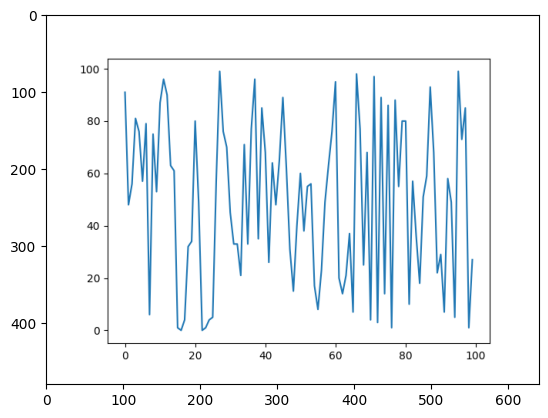

In [ ]:
# show the plot
print(os.listdir(temp_dir))
img = plt.imread(os.path.join(temp_dir, "line.png"))
plt.imshow(img)

# Agentic Workflow

Define two agents:

## code_writer_agent

1. Suggest Python or Shell code to user to execute (in code block but no execution by this agent)
2. Suggest packages if needed
3. Suggest code to collect information if needed
3. Come up with plan if not provided
4. Generate code rules (such as code indicator, complete code, save file, single code block, print output)
5. Check the execution results. If there is 


## code_executor_agent (Always requires human input for security)

Then, code_executor_agent initiates chat with code_writer_agent and task 

In [ ]:
# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful code writing AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.

1. If you need any packages to be installed, suggest the shell script to install the packages.

2. When you need to collect info, use the code to output the info you need, for example:

- browse or search the web
- download/read a file
- print the content of a webpage or a file
- get the current date/time, check the operating system.

After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.

3. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly. Solve the task step by step if you need to. 

- If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
- When using code, you must indicate the script type in the code block. 
- The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. 
- The user can't modify your code. So do not suggest incomplete code which requires users to modify. 
- Don't use a code block if it's not intended to be executed by the user.
- If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. 
- Don't include multiple code blocks in one response. 
- Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. 
- Check the execution result returned by the user. If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. 
- If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
- When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.

Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message, # system msg here
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution for this agent.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": docker_executor},  # Use the local command line code executor.
    human_input_mode="ALWAYS",  # Always take human input for this agent for safety.
)

In [ ]:
# code_executor_agent initiates chat with code_writer_agent and task 
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Write Python code to calculate the 14th Fibonacci number.",
)

code_executor_agent (to code_writer_agent):

Write Python code to calculate the 14th Fibonacci number.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To calculate the 14th Fibonacci number, we can use a simple iterative method. Fibonacci numbers are created by the addition of the two previous numbers in the sequence, starting from 0 and 1.

Here's the Python code to calculate and print the 14th Fibonacci number:

```python
def fibonacci(n):
    if n <= 0:
        return 0
    elif n == 1:
        return 1
    else:
        a, b = 0, 1
        for _ in range(2, n+1):
            a, b = b, a + b
        return b

# Calculate the 14th Fibonacci number (considering 0th as 0)
fib_number = fibonacci(14)
print("The 14th Fibonacci number is:", fib_number)
```

You can run this code in any Python environment, and it will directly output the 14th Fibonacci number.

----------------------

In [ ]:
# the automatic generated code uses yfinance to get the stock data
# you have to install yfinance in the docker container

import datetime

today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA and META stock price gains YTD, and save the plot to a file named 'stock_gains.png'.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-04-30. Write Python code to plot TSLA and META stock price gains YTD, and save the plot to a file named 'stock_gains.png'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

To plot the year-to-date (YTD) gains of TSLA (Tesla) and META (Meta Platforms, formerly Facebook) stocks, I will outline the following steps:

1. Install necessary Python packages for data retrieval and plotting.
2. Retrieve stock data for Tesla and Meta Platforms starting from the beginning of the year 2024 up to today.
3. Calculate the stock price gains based on the closing prices.
4. Plot the gains and save the plot as 'stock_gains.png'.

Let's start by installing the required packages. You'll need `pandas`, `yfinance` for fetching stock data, and `matplotlib` for plotting. Run the following command in your shell to install them:

```sh
pip install p

https://microsoft.github.io/autogen/docs/reference/agentchat/user_proxy_agent/

UserProxyAgent is a subclass of ConversableAgent configured with human_input_mode to ALWAYS and llm_config to False. By default, the agent will prompt for human input every time a message is received. Code execution is enabled by default. LLM-based auto reply is disabled by default. To modify auto reply, register a method with register_reply. To modify the way to get human input, override get_human_input method. To modify the way to execute code blocks, single code block, or function call, override execute_code_blocks, run_code, and execute_function methods respectively.

In [ ]:
# create an AssistantAgent named "assistant"
assistant = AssistantAgent(
    name="assistant",
    llm_config=llm_config
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": docker_executor,
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------


assistant (to user_proxy):

First, let's get the current date using Python. Please run the following Python code to obtain today's date:

```python
# filename: get_current_date.py
import datetime

# Get the current date
current_date = datetime.datetime.now()

# Print the current date
print("Today's date is:", current_date.strftime("%Y-%m-%d"))
```

After running this code, please provide the output here.

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING CODE BLOCK (inferred language is python)...
user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: Today's date is: 2024-04-30


--------------------------------------------------------------------------------
assistant (to user_proxy):

Thank you for providing today's date, which is April 30, 2024.

Next, we need to compare the year-to-date (YTD) gain for Meta Platforms, Inc. (META) and Tesla, Inc. (TESLA). To do this, we'll need to fetch the stock prices for both 